In [1]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability
import lnPi.monoutils

#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# create a reference lnPi_phases for bulk case

In [2]:
pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu


# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',fill_value=np.nan,
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases_mu([None])

In [3]:
# create a phase object
p = PhaseCreator.build_phases()
p.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

## create a collection

In [4]:
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
import joblib
set_loky_pickler('pickle')

In [5]:
lnzs = np.linspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 50)

In [22]:
#%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_use=True, tqdm_leave=True, joblib_use=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases=build_phases, concat_coords='different', 
                                       unstack=True, set_index=['lnz_0','phase'], clean_coords=True )

In [23]:
mask = c.xgce.edge_distance(ref).min('phase') > 8

In [24]:
c = c[mask.values]

In [25]:
c.spinodals(2, build_phases, inplace=True, append=True)
c.binodals(2, build_phases, inplace=True, append=True)
spin = c.spinodals.access
bino = c.binodals.access

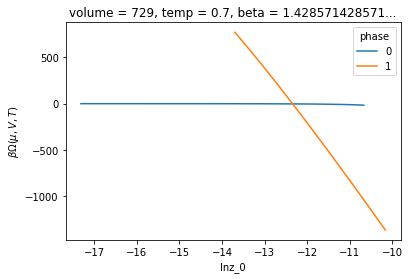

In [26]:
c.xgce_prop.betaOmega().unstack().plot(hue='phase')

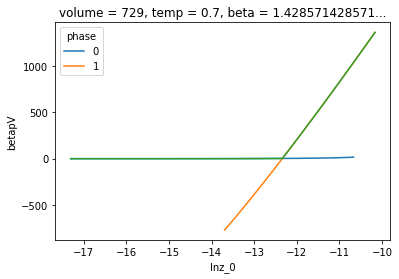

In [27]:
c.xgce_prop.table(dim_to_suffix='component', mask_stable=False).betapV.unstack().plot(hue='phase')
c.xgce_prop.table(dim_to_suffix='component', mask_stable=True).betapV.unstack().plot(hue='phase')

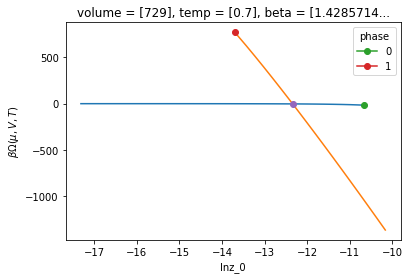

In [28]:
c.xgce.betaOmega().plot(hue='phase')
(
    spin.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .plot(hue='phase', marker='o')
)

bino.xgce.betaOmega().sel(phase=0).plot.line(marker='o', label='binodal')




In [29]:
# mu min/max

In [35]:
reload(lnPi.monoutils)

<module 'lnPi.monoutils' from '/Users/wpk/Documents/python/lnPi/monoutils.py'>

In [54]:
c_course, c = lnPi.monoutils.limited_collection(build_phases, lnz_range=np.round(ref.lnz + [-10, +10], 1), dlnz=0.1, 
                                                rho_min=0.0001, edge_distance_min=8, 
                                                collection_kws={'unstack':True,'set_index':['lnz_0','phase']})

In [55]:
c.spinodals(2, build_phases, inplace=True, append=True)
c.binodals(2, build_phases, inplace=True, append=True)

In [56]:
c.sort_by_lnz()

In [57]:
table = c.xgce_prop.table(['dens','pressure'], mask_stable=True, dim_to_suffix='component')

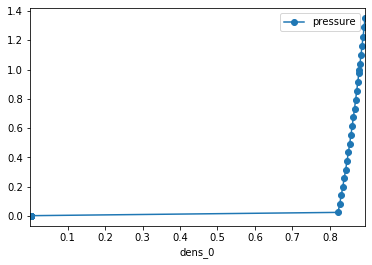

In [58]:
table.to_dataframe().plot('dens_0','pressure', marker='o')

In [59]:
import xarray as xr
@xr.register_dataarray_accessor('lwhere')
def lwhere(da):
    def where(condition, drop=False):
        return da.where(condition(da), drop=drop)
    return where

In [60]:
# test saving

In [61]:
da = (
    c.to_dataarray()
    .pipe(c.spinodals.assign_coords)
    .pipe(c.binodals.assign_coords)
    .sortby('lnz_0')
    .reset_index('rec', drop=True)
)

In [62]:
c2 = lnPi.CollectionPhases.from_dataarray(ref, da, unstack=True, set_index=['lnz_0','phase'])
c2.spinodals.from_dataarray(da)
c2.binodals.from_dataarray(da)

In [63]:
c.binodals.access.xgce_prop.table()

<xarray.Dataset>
Dimensions:  (component: 1, lnz_0: 1, phase: 2)
Coordinates:
    volume   (lnz_0) int64 729
    temp     (lnz_0) float64 0.7
    beta     (lnz_0) float64 1.429
    rec      (lnz_0) int64 0
  * lnz_0    (lnz_0) float64 -12.34
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    nvec     (component, lnz_0, phase) float64 2.558 597.9
    betapV   (lnz_0, phase) float64 2.475 2.475
    PE_n     (lnz_0, phase) float64 -0.04095 -5.578

In [64]:
c2.binodals.access.xgce_prop.table()#.swap_dims({'rec':'lnz_0'})

<xarray.Dataset>
Dimensions:  (component: 1, lnz_0: 1, phase: 2)
Coordinates:
    volume   (lnz_0) int64 729
    temp     (lnz_0) float64 0.7
    beta     (lnz_0) float64 1.429
    rec      (lnz_0) int64 0
  * lnz_0    (lnz_0) float64 -12.34
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    nvec     (component, lnz_0, phase) float64 2.558 597.9
    betapV   (lnz_0, phase) float64 2.475 2.475
    PE_n     (lnz_0, phase) float64 -0.04095 -5.578

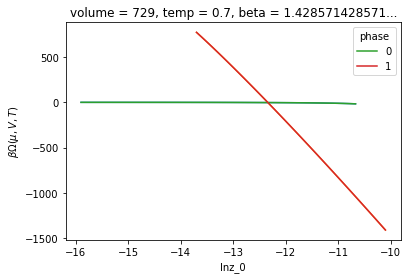

In [65]:
c.xgce.betaOmega().plot(hue='phase')
c2.xgce.betaOmega().plot(hue='phase')

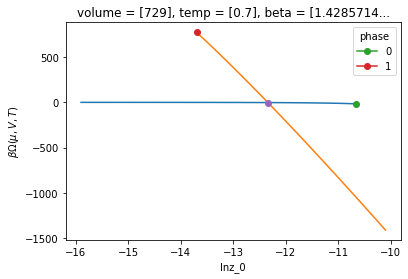

In [67]:
c.xgce.betaOmega().plot(hue='phase')

(
    c.spinodals.access.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

# bulk 065

In [75]:
reload(lnPi.monoutils)

<module 'lnPi.monoutils' from '/Users/wpk/Documents/python/lnPi/monoutils.py'>

In [132]:
beta = 1.0 / 0.65

In [133]:
ref_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', lnz=-4.453015418106743E+00 /0.65,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))
phase_creator_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_bulk, 
                                         merge_kws=dict(efac=0.5), tag_phases=tag_phases2)
build_phases_bulk = phase_creator_bulk.build_phases_mu([None])

In [145]:
c_course_bulk, c_bulk = lnPi.monoutils.limited_collection(build_phases_bulk, 
                                                np.round(ref_bulk.lnz + [-10, +10], 1), 0.05, edge_distance_min=8,
                                                         collection_kws=dict(set_index=['lnz_0','phase']))

In [146]:
c_course_bulk.spinodals(2, build_phases_bulk, inplace=True)
c_course_bulk.binodals(2, build_phases_bulk, inplace=True)

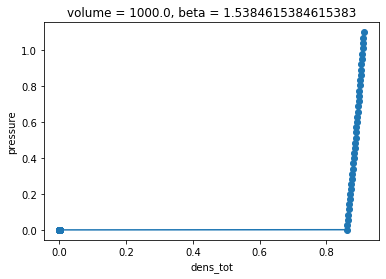

In [151]:
(
    c_bulk.xgce_prop.table(['dens_tot','pressure'], mask_stable=True)
    #.swap_dims({'rec':'lnz_0'})
     .swap_dims({'lnz_0':'dens_tot'})
     .pressure.plot(marker='o')
    
)

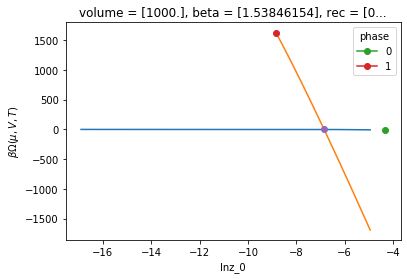

In [154]:
c_bulk.xgce.betaOmega().plot(hue='phase')

(
    c_course_bulk.spinodals.access.xgce.betaOmega()
    
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c_course_bulk.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

# confined

In [155]:
ref_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',
                                       lnz=-0.500000E+01/0.65,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phase_creator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_conf, 
                                              merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

In [156]:
build_phases_conf = phase_creator_conf.build_phases_mu([None])

In [172]:
c_course_bulk.binodals.access.lnz[0,0]

-6.8518860562331465

In [246]:
lnzs_conf = np.geomspace(np.log(1e-7), c_course_bulk.binodals.access.lnz[0,0], 200)
c_conf = lnPi.CollectionPhases.from_builder(lnzs_conf, build_phases_conf, set_index=['lnz_0','phase'])

In [247]:
c_conf.xgce.edge_distance(ref_conf).min('phase').min()

<xarray.DataArray 'edge_distance' ()>
array(286.)
Coordinates:
    volume   float64 7e+03
    beta     float64 1.538

In [248]:
c_conf.spinodals(2, build_phases_conf, inplace=True, append=True)
c_conf.binodals(2, build_phases_conf, inplace=True, append=True)

In [249]:
c_conf.sort_by_lnz()

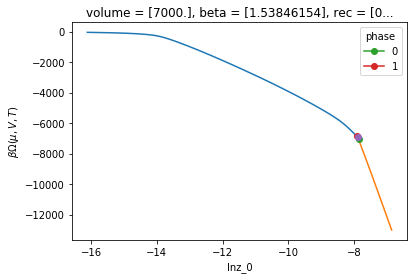

In [250]:
c_conf.xgce.betaOmega().plot(hue='phase')

(
    c_conf.spinodals.access.xgce.betaOmega()
    
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c_conf.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

In [187]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


# make isotherm

In [251]:
# new bulk on same spacinf
c_bulk = lnPi.CollectionPhases.from_builder(c_conf.lnz[:,0], build_phases_bulk, set_index=['lnz_0','phase'])

In [252]:
lnz_spin = c_conf.spinodals.access.lnz[:,0]

In [253]:
psat = c_course_bulk.binodals.access.xgce_prop.pressure().values.flatten()[0]

In [254]:
table_bulk = (
    c_bulk.xgce_prop.table(['pressure'], mask_stable=True)
    .assign(pscaled=lambda x: x.pressure / psat)
    .drop('volume')
)

In [255]:
table_conf = (
    c_conf.xgce_prop.table(['ntot'])
    .drop('volume')
)

In [276]:
isotherm = (
    xr.merge((table_bulk.pscaled, table_conf.ntot))
    .set_coords('pscaled')
    .ntot
)
isotherm

<xarray.DataArray 'ntot' (lnz_0: 203, phase: 2)>
array([[  29.625822,         nan],
       [  31.081696,         nan],
       [  32.640422,         nan],
       ...,
       [        nan, 6004.87468 ],
       [        nan, 6008.203599],
       [        nan, 6012.530636]])
Coordinates:
    beta     float64 1.538
    rec      (lnz_0) float64 0.0 1.0 2.0 3.0 4.0 ... 199.0 200.0 201.0 202.0
  * lnz_0    (lnz_0) float64 -16.12 -16.05 -15.98 ... -6.911 -6.881 -6.852
    pscaled  (lnz_0) float64 9.347e-05 0.0001002 0.0001073 ... 0.9419 0.9706 1.0
  * phase    (phase) int64 0 1
Attributes:
    standard_name:  total_particles
    long_name:      $n(\mu,V,T)$

(0, 1.0)

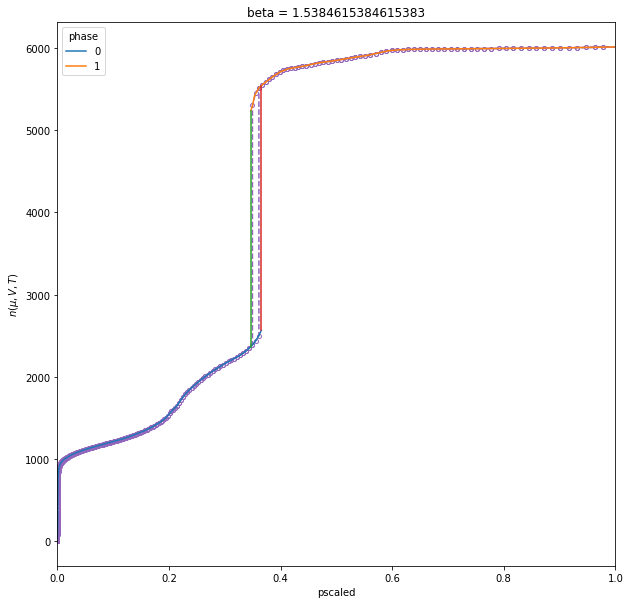

In [261]:
fig,ax = plt.subplots(figsize=(10,10))

isotherm.swap_dims({'lnz_0':'pscaled'}).plot(hue='phase')

for meta, g in isotherm.sel(lnz_0=lnz_spin).to_dataframe().reset_index().groupby('lnz_0'):
    plt.plot(g['pscaled'],g['ntot'])
    
plt.plot(df.pscaled,df.rho, marker='o',mfc='None', ls='--',zorder=-1, ms=4)
plt.gca().set_xlim(0,1.0)